In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%cd '/content/drive/MyDrive/Deep_learning'

/content/drive/MyDrive/Deep_learning


In [3]:
import torch
import torch.nn as nn
from torch.nn import functional as F
import torchvision
import torchvision.transforms as transforms
from torchvision import datasets

In [20]:
class ResNeXtBlock(nn.Module):
    """The ResNeXt block."""
    def __init__(self, num_channels, groups, bot_mul, use_1x1conv=False,
                 strides=1):
        super().__init__()
        bot_channels = int(round(num_channels * bot_mul))
        self.conv1 = nn.LazyConv2d(bot_channels, kernel_size=1, stride=1)
        self.conv2 = nn.LazyConv2d(bot_channels, kernel_size=3,
                                   stride=strides, padding=1,
                                   groups=bot_channels//groups)
        self.conv3 = nn.LazyConv2d(num_channels, kernel_size=1, stride=1)
        self.bn1 = nn.LazyBatchNorm2d()
        self.bn2 = nn.LazyBatchNorm2d()
        self.bn3 = nn.LazyBatchNorm2d()
        if use_1x1conv:
            self.conv4 = nn.LazyConv2d(num_channels, kernel_size=1,
                                       stride=strides)
            self.bn4 = nn.LazyBatchNorm2d()
        else:
            self.conv4 = None

    def forward(self, X):
        Y = F.relu(self.bn1(self.conv1(X)))
        Y = F.relu(self.bn2(self.conv2(Y)))
        Y = self.bn3(self.conv3(Y))
        if self.conv4:
            X = self.bn4(self.conv4(X))
        return F.relu(Y + X)

In [16]:
class AnyNet(nn.Module):
    def stem(self, num_channels):
        return nn.Sequential(
            nn.LazyConv2d(num_channels, kernel_size = 3, stride = 2, padding = 1),
            nn.LazyBatchNorm2d(), nn.ReLU()
        )
    
    def stage(self, depth, num_channels, groups, bot_mul):
        blk = []
        for i in range(depth):
            if i == 0:
                blk.append(ResNeXtBlock(num_channels, groups, bot_mul, use_1x1conv=True, strides = 2))
            else:
                blk.append(ResNeXtBlock(num_channels, groups, bot_mul))
        return nn.Sequential(*blk)

    def __init__(self, arch, stem_channels, lr = 0.1, num_classes = 10):
        super(AnyNet, self).__init__()
        self.lr = lr
        self.num_classes = num_classes
        self.net = nn.Sequential(self.stem(stem_channels))
        for i, s in enumerate(arch):
            self.net.add_module(f'stage{i+1}', self.stage(*s))
        self.net.add_module('head', nn.Sequential(
            nn.AdaptiveAvgPool2d((1, 1)), nn.Flatten(),
            nn.LazyLinear(num_classes)
        ))

    def apply_init(self, inputs, init = None):
        self.forward(*inputs)
        if init is not None:
            self.net.apply(init)

    def forward(self, X):
        return self.net(X)

In [17]:
class RegNetX32(AnyNet):
    def __init__(self, lr = 0.1, num_classes = 10):
      stem_channels, groups, bot_mul = 32, 16, 1
      depths, channels = (4, 6), (32, 80)
      super().__init__(
          ((depths[0], channels[0], groups, bot_mul),
           (depths[1], channels[1], groups, bot_mul)),
           stem_channels, lr, num_classes
      )

In [7]:
from pytorchcv import train_mul, plot_results, layer_summary, init_cnn

In [9]:
std_normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                          std=[0.229, 0.224, 0.225])
trans = transforms.Compose([transforms.Resize(96), transforms.ToTensor(), std_normalize])

data_train = datasets.CIFAR10(
    root = './data',
    train = True,
    download = True,
    transform = trans
)

data_val = datasets.CIFAR10(
    root = './data',
    train = False,
    download = True,
    transform = trans
)

Files already downloaded and verified
Files already downloaded and verified


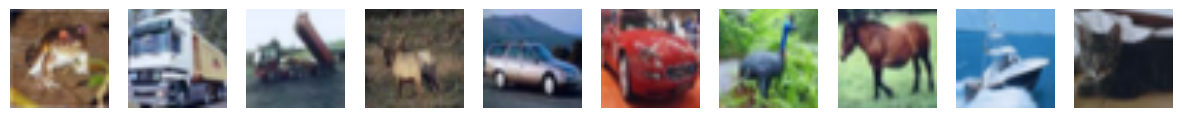

In [10]:
from pytorchcv import display_dataset
display_dataset(data_train)

In [11]:
train_loader = torch.utils.data.DataLoader(data_train, batch_size = 128, shuffle = True, pin_memory = True)
val_loader = torch.utils.data.DataLoader(data_val, batch_size = 128, pin_memory = True)

In [12]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [21]:
net = RegNetX32()
net.apply_init([next(iter(train_loader))[0]], init_cnn)

In [25]:
layer_summary(net.net.to(device),input_size = [1,3,96,96],)

Sequential output shape:	 torch.Size([1, 32, 48, 48])
Sequential output shape:	 torch.Size([1, 32, 24, 24])
Sequential output shape:	 torch.Size([1, 80, 12, 12])
Sequential output shape:	 torch.Size([1, 10])


In [27]:
!pip install torchinfo
from torchinfo import summary
summary(net, input_size = [1, 3, 96, 96])

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


/usr/local/lib/python3.9/dist-packages/torchinfo/torchinfo.py:477: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  action_fn=lambda data: sys.getsizeof(data.storage()),
/usr/local/lib/python3.9/dist-packages/torch/storage.py:665: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return super().__sizeof__() + self.nbytes()


Layer (type:depth-idx)                   Output Shape              Param #
RegNetX32                                [1, 10]                   --
├─Sequential: 1-1                        [1, 10]                   --
│    └─Sequential: 2-1                   [1, 32, 48, 48]           --
│    │    └─Conv2d: 3-1                  [1, 32, 48, 48]           896
│    │    └─BatchNorm2d: 3-2             [1, 32, 48, 48]           64
│    │    └─ReLU: 3-3                    [1, 32, 48, 48]           --
│    └─Sequential: 2-2                   [1, 32, 24, 24]           --
│    │    └─ResNeXtBlock: 3-4            [1, 32, 24, 24]           8,064
│    │    └─ResNeXtBlock: 3-5            [1, 32, 24, 24]           6,944
│    │    └─ResNeXtBlock: 3-6            [1, 32, 24, 24]           6,944
│    │    └─ResNeXtBlock: 3-7            [1, 32, 24, 24]           6,944
│    └─Sequential: 2-3                   [1, 80, 12, 12]           --
│    │    └─ResNeXtBlock: 3-8            [1, 80, 12, 12]           24,00

In [29]:
optimizer = torch.optim.SGD(net.parameters(), lr = net.lr, momentum = 0.9, nesterov = True)
hist = train_mul(net, train_loader, val_loader, optimizer = optimizer, epochs = 5, loss_fn = nn.CrossEntropyLoss())

Epoch  0, Train acc=0.375, Val acc=0.459, Train loss=0.013, Val loss=0.012, Time=58.766
Epoch  1, Train acc=0.579, Val acc=0.568, Train loss=0.009, Val loss=0.010, Time=57.597
Epoch  2, Train acc=0.669, Val acc=0.668, Train loss=0.007, Val loss=0.007, Time=57.508
Epoch  3, Train acc=0.718, Val acc=0.675, Train loss=0.006, Val loss=0.007, Time=56.955
Epoch  4, Train acc=0.756, Val acc=0.713, Train loss=0.005, Val loss=0.007, Time=57.481


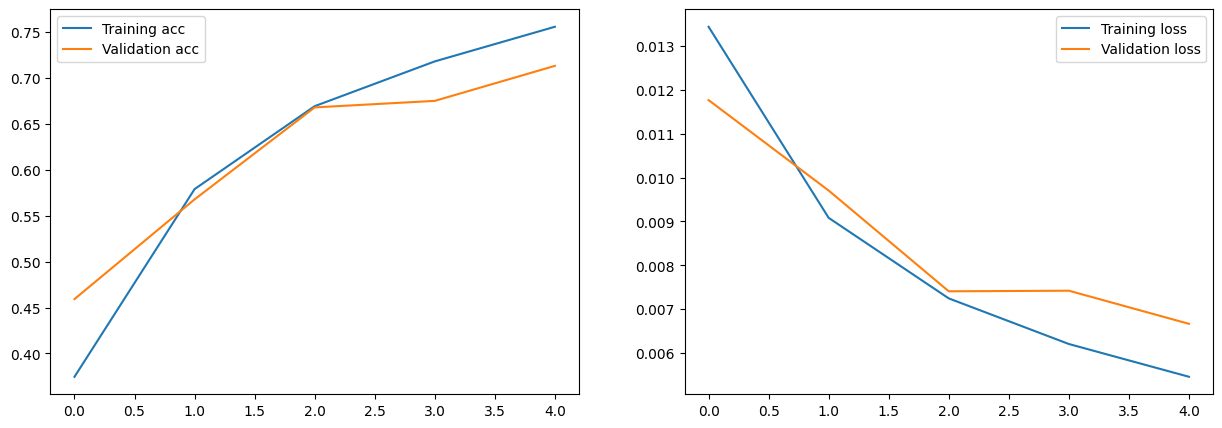

In [30]:
plot_results(hist)

In [31]:
import utils

Text(0.5, 1.0, 'label: 0')

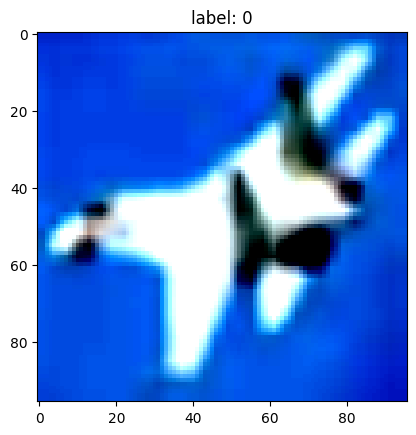

In [32]:
import numpy as np
import matplotlib.pyplot as plt
img, label = data_val[np.random.randint(8,21)]
plt.imshow(img.permute(1,2,0))
plt.title(f'label: {label}')

In [33]:
prob = net(img.unsqueeze(0).to('cuda'))
softmax = nn.Softmax()
prob = softmax(prob)
print(prob)

tensor([[7.1567e-01, 4.2803e-04, 6.7497e-03, 5.0873e-02, 1.6626e-02, 2.4766e-02,
         6.4680e-03, 1.7790e-03, 1.7563e-01, 1.0076e-03]], device='cuda:0',
       grad_fn=<SoftmaxBackward0>)


<ipython-input-33-7fb306ad7e93>:3: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  prob = softmax(prob)


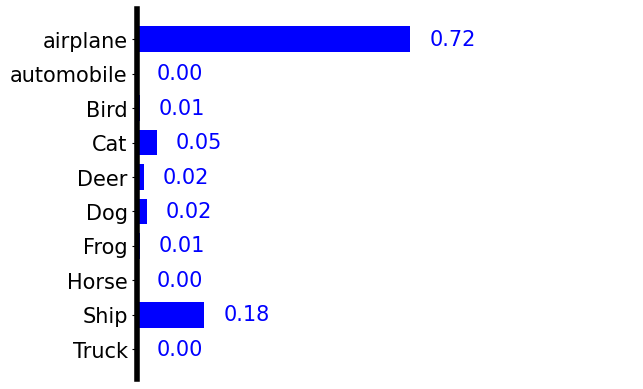

In [34]:
utils.show_prob_cifar(prob.to('cpu'))